In [16]:
from virtual_swap.vswap_pass import VirtualSwap
from qiskit import QuantumCircuit

# from qiskit.test import QiskitTestCase
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.passes import (
    Unroller,
    TrivialLayout,
    ApplyLayout,
    SabreLayout,
    CountOpsLongestPath,
    Collect1qRuns,
    Collect2qBlocks,
    ConsolidateBlocks,
)
from qiskit.transpiler.passes import OptimizeSwapBeforeMeasure
import numpy as np

from slam.utils.transpiler_pass.weyl_decompose import RootiSwapWeylDecomposition

# this code is buggy, see https://github.com/Qiskit/qiskit-terra/pull/9375
# I can't use this version bc qiskit version missing DAGCircuit functionality

# # build a toffoli
# qc = QuantumCircuit(8)
# qc.ccx(0, 1, 2)
# qc.cx(1, 7)
# qc.ccx(3, 4, 5)
# qc.ccx(2, 5, 6)
# # build a 2x2 square coupling map
# coupling = CouplingMap.from_line(8)

# # build a toffoli
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
linear = CouplingMap.from_line(4)
coupling = linear

# qc = QuantumCircuit(16)
# # generate network of random cnots
# for _ in range(20):
#     qc.cx(*np.random.choice(16, 2, replace=False))
# coupling = CouplingMap.from_grid(4, 4)

# # medium sized circuit
# qc = QuantumCircuit(16)
# # add some toffolis and cxs
# for _ in range(16):
#     # qc.ccx(*np.random.choice(8, 3, replace=False))
#     qc.cx(*np.random.choice(16, 2, replace=False))
# # coupling = CouplingMap.from_grid(2, 4)
coupling = CouplingMap.from_grid(6, 6)

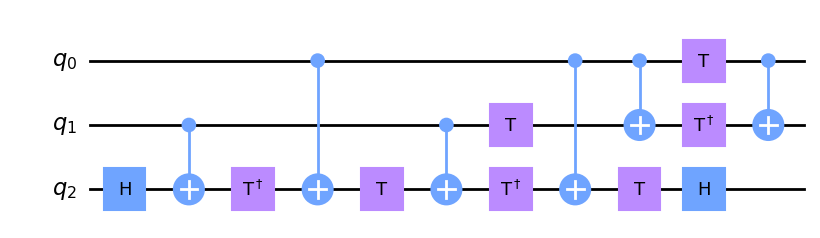

In [17]:
qc.decompose().draw("mpl")

Gate count: 18
Gate count critical path: 16


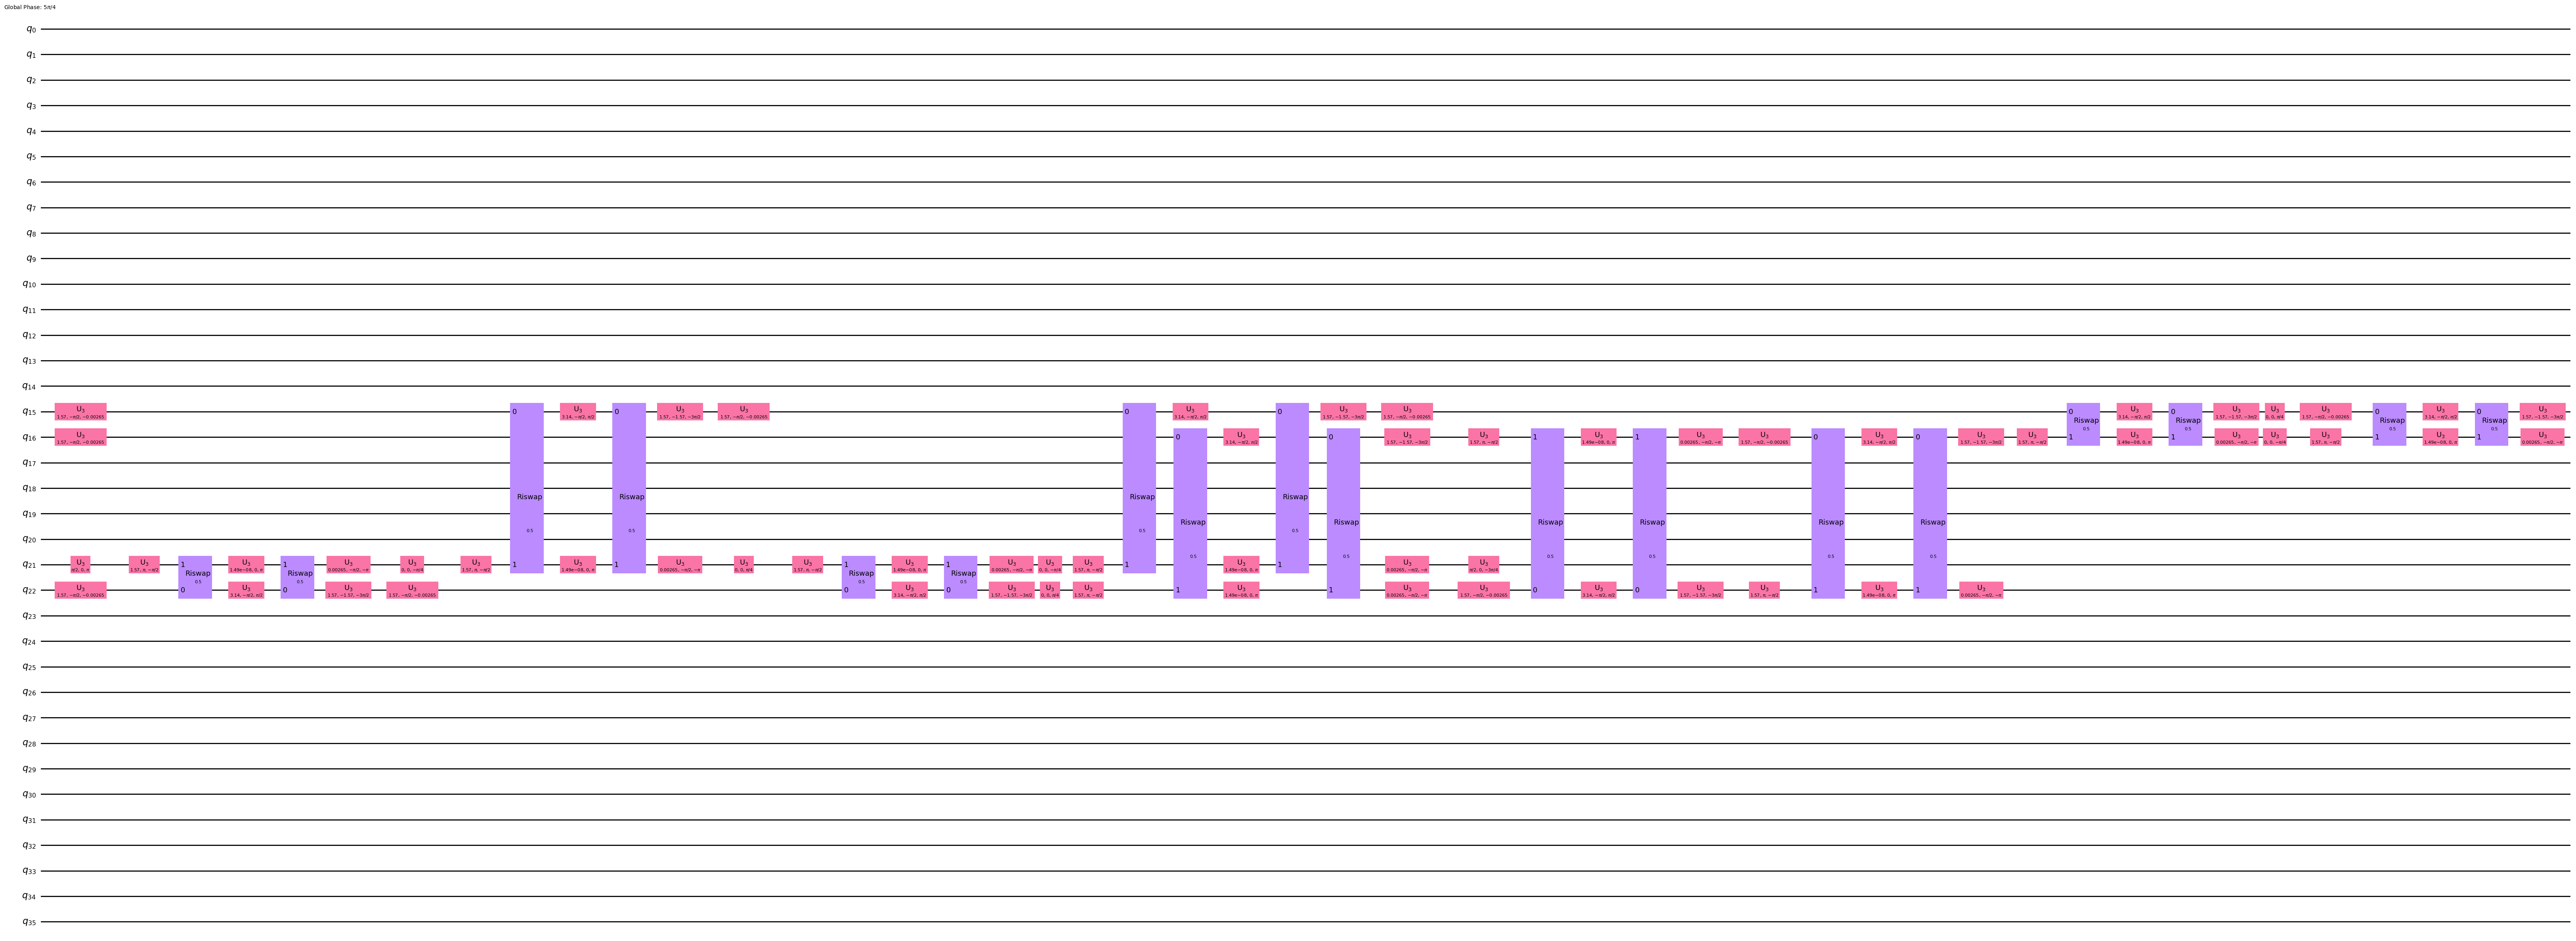

In [18]:
from qiskit import transpile

qc2 = transpile(
    qc, coupling_map=coupling, basis_gates=["cx", "u3"], optimization_level=3
)
t0_pm = PassManager([RootiSwapWeylDecomposition(), CountOpsLongestPath()])
qc3 = t0_pm.run(qc2)

# print(qc3.count_ops())
print(f"Gate count: {qc3.count_ops()['riswap']}")
# print(pm.property_set['count_ops_longest_path'])
# print(f"Depth: {qc3.depth()}")
print(
    f"Gate count critical path: {t0_pm.property_set['count_ops_longest_path']['riswap']}"
)
qc3.draw(output="mpl", fold=-1)

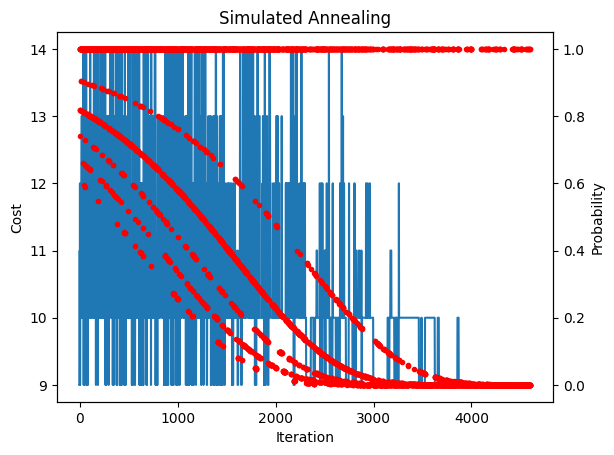

Gate count: 10
Longest path gate count: 10


In [25]:
from virtual_swap.vswap_simple import VirtualSwap
from qiskit.transpiler.passes import (
    SabreLayout,
    SetLayout,
    FullAncillaAllocation,
    EnlargeWithAncilla,
)
from virtual_swap.sqiswap_equiv import sel

# FIXME, giving the pretranspiler this probably is not good idea bc VirtualSwap is expecting cx gates
# probably a good idea to write in a way that can handle being given xx_plus_yy and mark into cx gates
# (reverse of the current implementation)


from qiskit.transpiler.basepasses import TransformationPass
from qiskit.converters import dag_to_circuit

prep_qc = transpile(
    qc, basis_gates=["u", "cx", "swap"], coupling_map=coupling, optimization_level=3
)
# # prep_qc = transpile(qc, basis_gates=["u", "xx_plus_yy", "swap"], coupling_map=coupling, optimization_level=3)
# from qiskit.transpiler import Layout
# layout = Layout(prep_qc._layout.input_qubit_mapping)
# # layout = Layout({k: v for k,v in layout.get_physical_bits().items() if not v.register.name == 'ancilla'})

# run the pass
pm = PassManager()
# need some basic unroll and layout
# pm.append([SetLayout(layout)])
# full ancilla extend
# pm.append([Unroller(["u", "cx"]), SetLayout(layout)])

# pm.append([PrePass(), Unroller(["u", "cx"])])#, SetLayout(layout)])

pm.append([Unroller(["u", "cx"]), TrivialLayout(coupling)])
pm.append([FullAncillaAllocation(coupling), EnlargeWithAncilla(), ApplyLayout()])
pm.append(VirtualSwap(coupling, visualize=True))
pm.append(OptimizeSwapBeforeMeasure())

# XXX use the PR version once merged into Qiskit
# pm.append([RootiSwapWeylDecomposition(), CountOpsLongestPath()])
pm.append(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(),
        RootiSwapWeylDecomposition(),
        CountOpsLongestPath(),
    ]
)
# pm.append([CountOpsLongestPath()])


# set debug logging
# import logging

# logger = logging.getLogger("VSWAP")
# logger.setLevel(logging.INFO)

new_circ = pm.run(prep_qc)


# sum the cost of gate 'cx' and 'iswap'
print(f"Gate count:", new_circ.count_ops().get("riswap", 0))
longest_path = pm.property_set["count_ops_longest_path"]
print(f"Longest path gate count:", longest_path.get("riswap", 0))

# # sum the cost of gate 'cx' and 'iswap'
# print(f"Gate count:", 2*new_circ.count_ops().get('iswap', 0) + 2*new_circ.count_ops().get('cx', 0) + 3*new_circ.count_ops().get('swap', 0))
# longest_path = pm.property_set["count_ops_longest_path"]
# print(f"Longest path gate count:", 2*longest_path.get('iswap', 0) + 2*longest_path.get('cx', 0) + 3*longest_path.get('swap', 0))

In [26]:
# new_circ.draw(output='mpl', fold=-1)

  0%|          | 0/22 [00:00<?, ?it/s]

Transpiling with transpiler 1
Depth: 472
Transpiling with transpiler 2


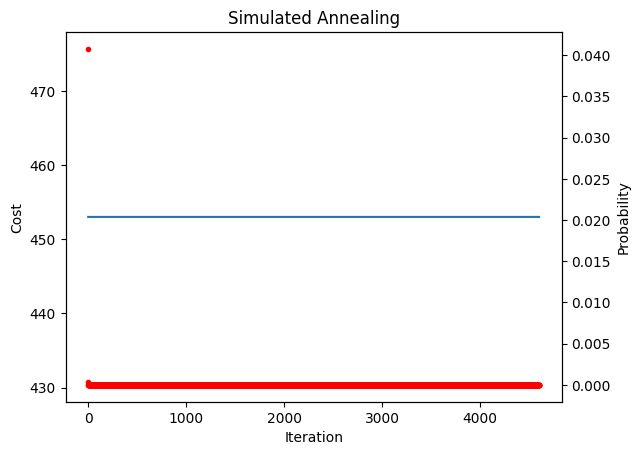

Depth: 591
Transpiling with transpiler 3


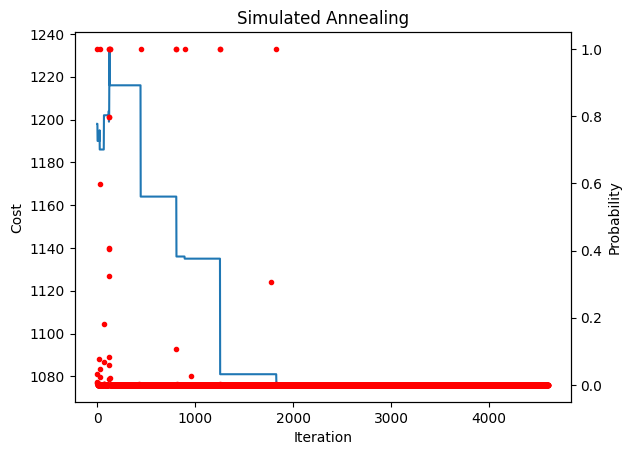

  5%|▍         | 1/22 [00:27<09:44, 27.83s/it]

Depth: 766
Transpiling with transpiler 1
Depth: 58
Transpiling with transpiler 2


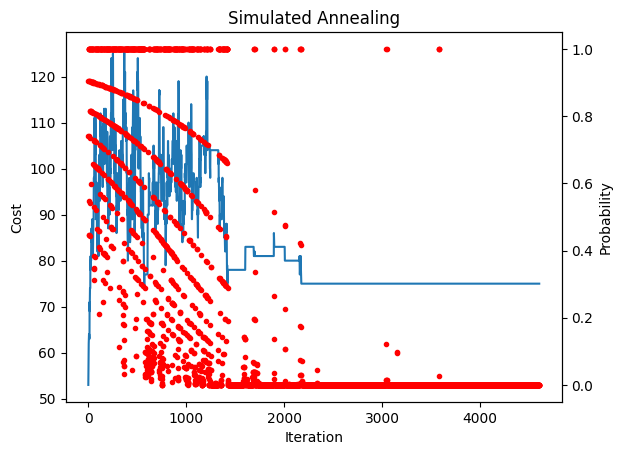

Depth: 61
Transpiling with transpiler 3


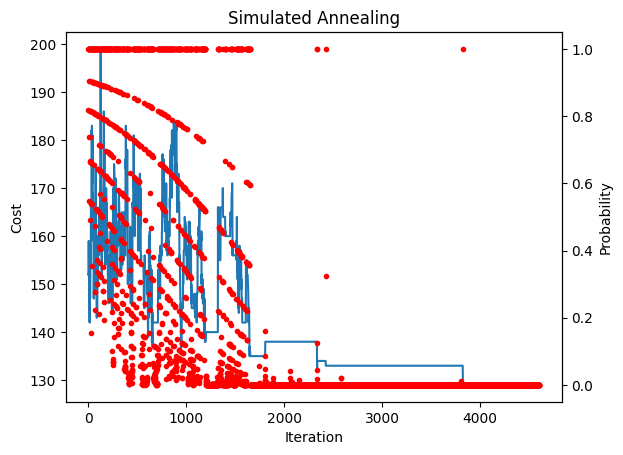

  9%|▉         | 2/22 [05:15<1:00:15, 180.79s/it]

Error: negative dimensions are not allowed
Transpiling with transpiler 1
Depth: 63
Transpiling with transpiler 2


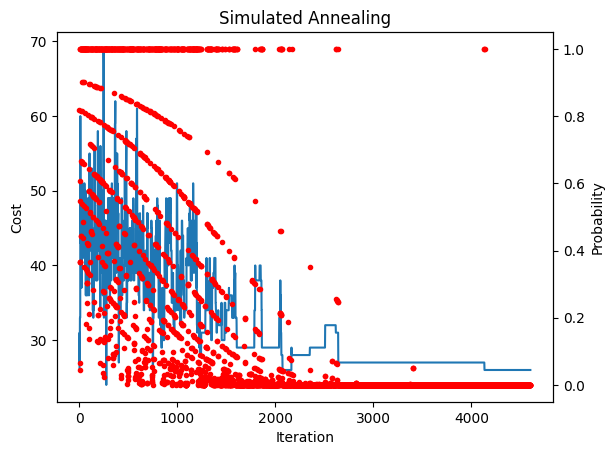

 14%|█▎        | 3/22 [05:22<32:02, 101.21s/it]  

Error: must be real number, not Measure


 18%|█▊        | 4/22 [05:29<19:11, 63.96s/it] 

Transpiling with transpiler 1
Depth: 10
Transpiling with transpiler 2


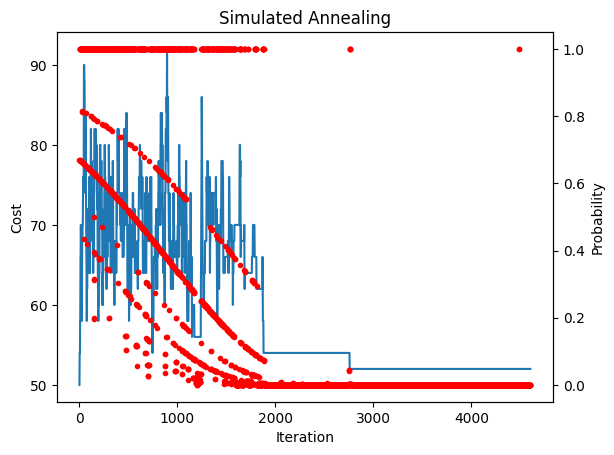

Depth: 4
Transpiling with transpiler 3


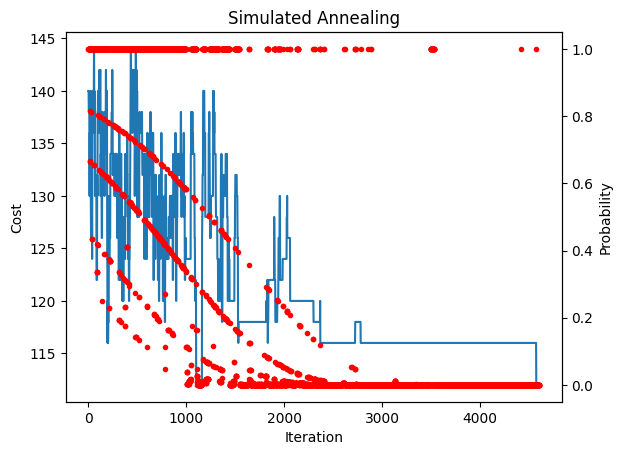

 23%|██▎       | 5/22 [10:52<44:37, 157.50s/it]

Error: Gates must have a 4×4 shape
Transpiling with transpiler 1
Depth: 306
Transpiling with transpiler 2


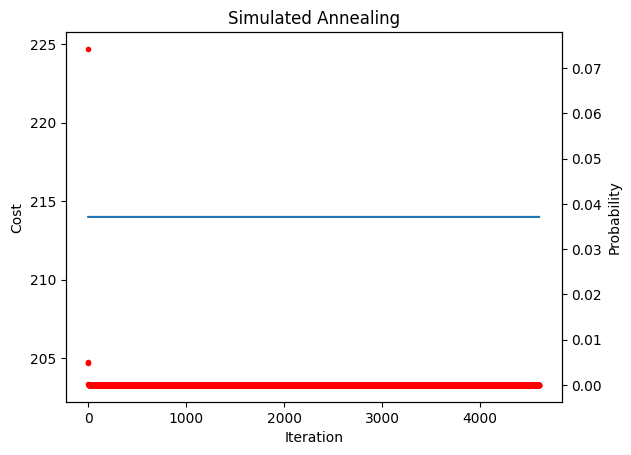

Depth: 292
Transpiling with transpiler 3


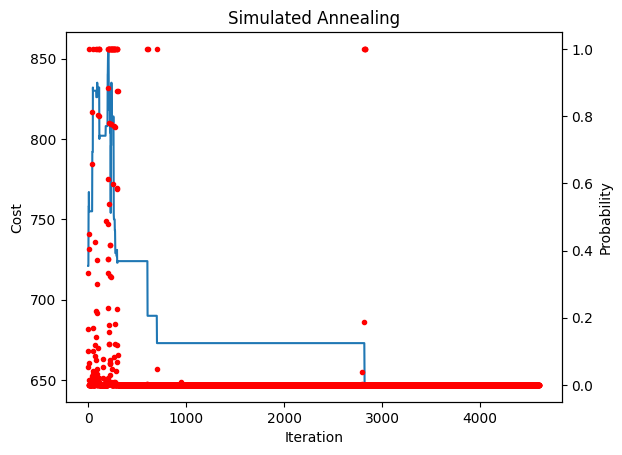

 27%|██▋       | 6/22 [11:09<29:16, 109.77s/it]

Error: negative dimensions are not allowed
Transpiling with transpiler 1
Depth: 46
Transpiling with transpiler 2


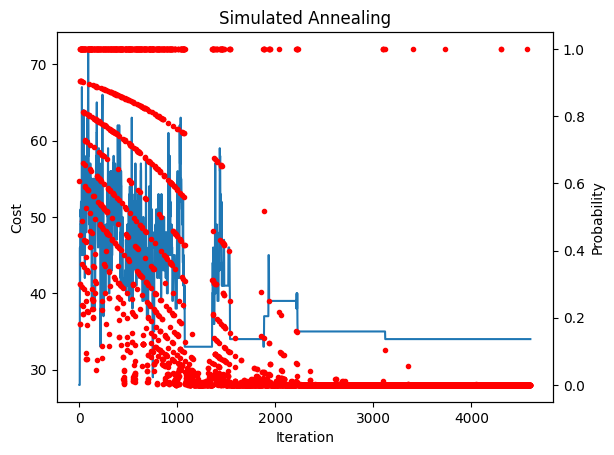

 32%|███▏      | 7/22 [11:15<18:55, 75.73s/it] 

Error: negative dimensions are not allowed
Transpiling with transpiler 1
Depth: 33
Transpiling with transpiler 2


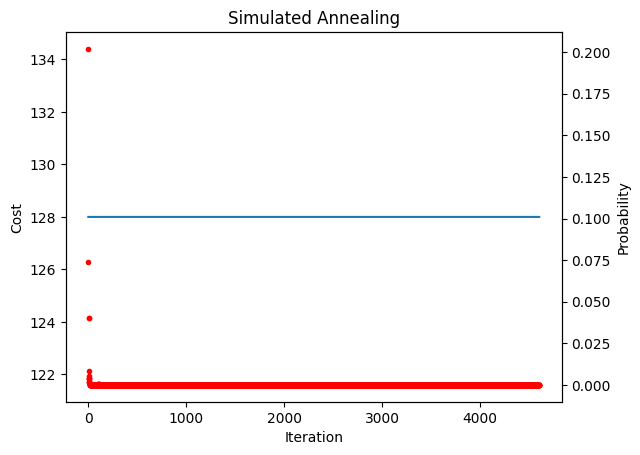

Depth: 31
Transpiling with transpiler 3


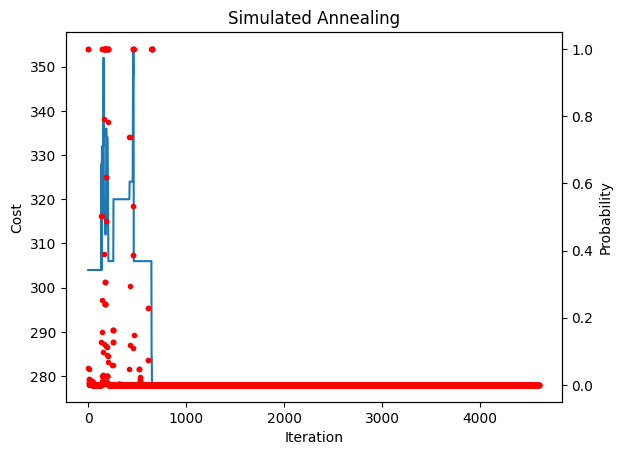

 36%|███▋      | 8/22 [11:46<14:22, 61.58s/it]

Error: negative dimensions are not allowed
Transpiling with transpiler 1
Depth: 232
Transpiling with transpiler 2


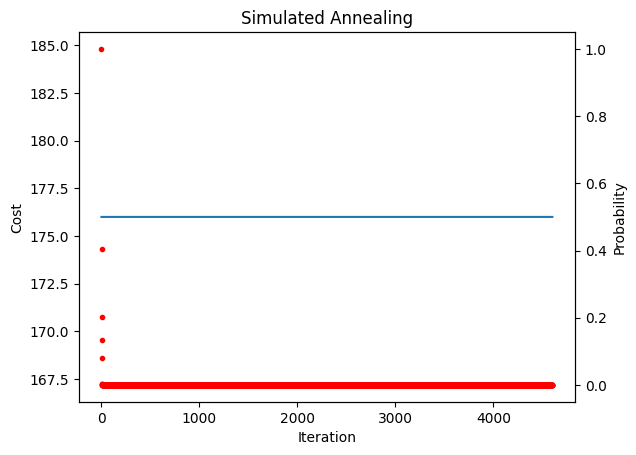

Depth: 165
Transpiling with transpiler 3


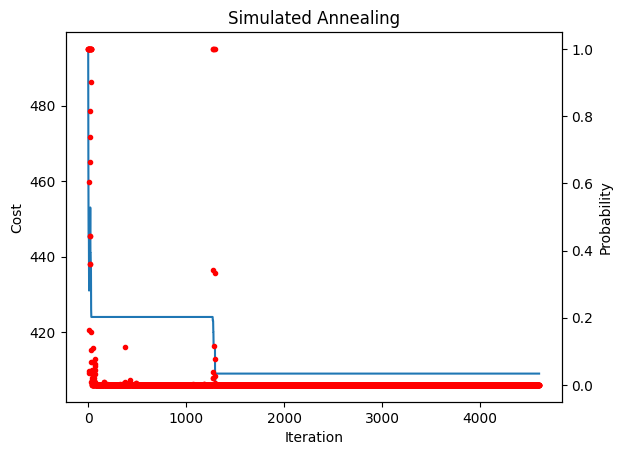

 45%|████▌     | 10/22 [12:01<07:10, 35.90s/it]

Depth: 292
Transpiling with transpiler 1
Depth: 218
Transpiling with transpiler 2


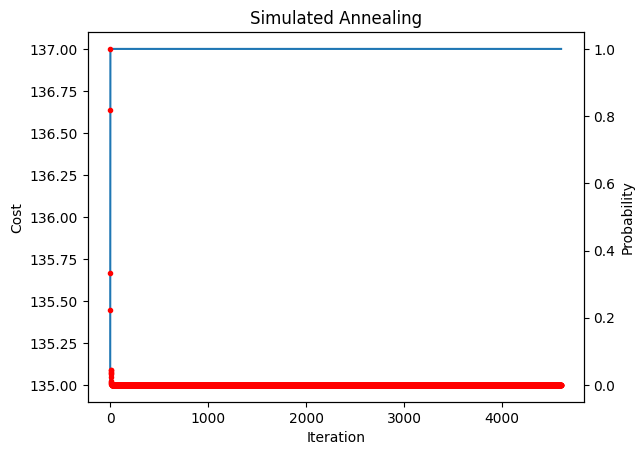

Depth: 139
Transpiling with transpiler 3


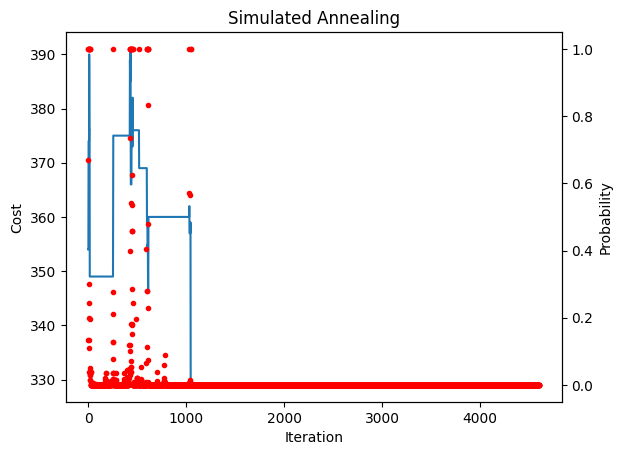

 50%|█████     | 11/22 [12:15<05:34, 30.39s/it]

Depth: 234
Transpiling with transpiler 1
Depth: 367
Transpiling with transpiler 2


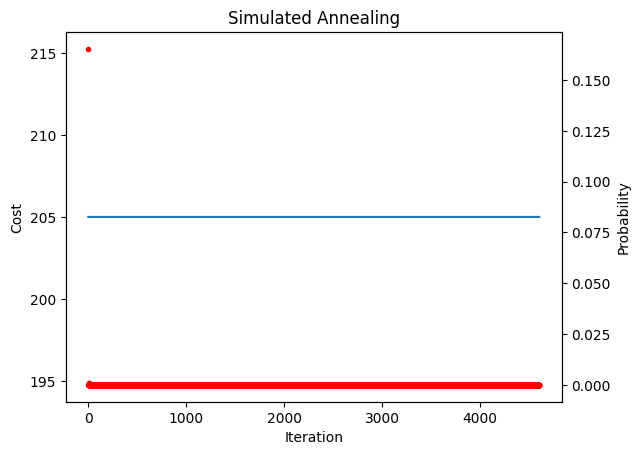

Depth: 265
Transpiling with transpiler 3


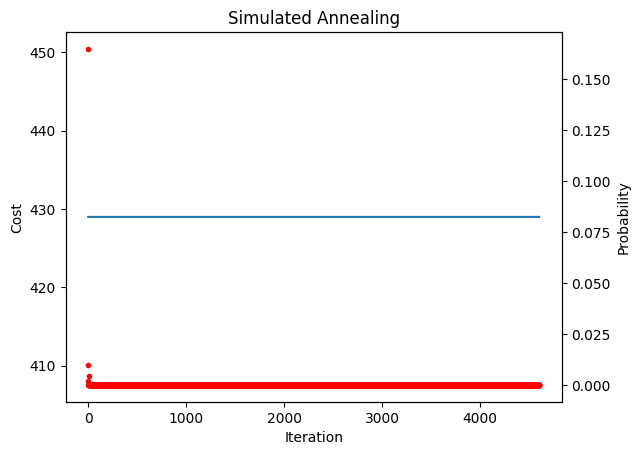

 55%|█████▍    | 12/22 [12:33<04:29, 26.91s/it]

Error: negative dimensions are not allowed
Transpiling with transpiler 1
Depth: 618
Transpiling with transpiler 2


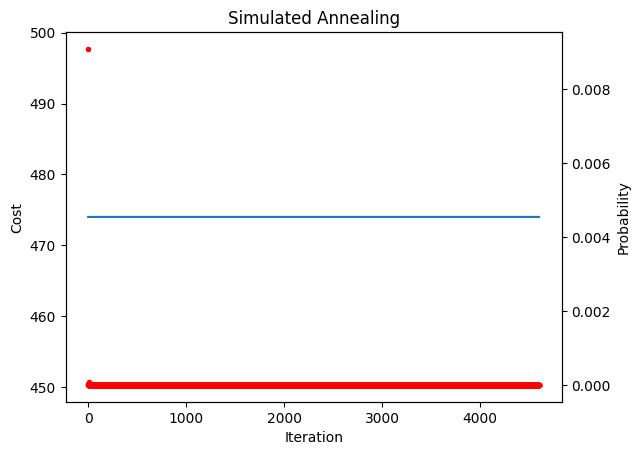

Depth: 740
Transpiling with transpiler 3


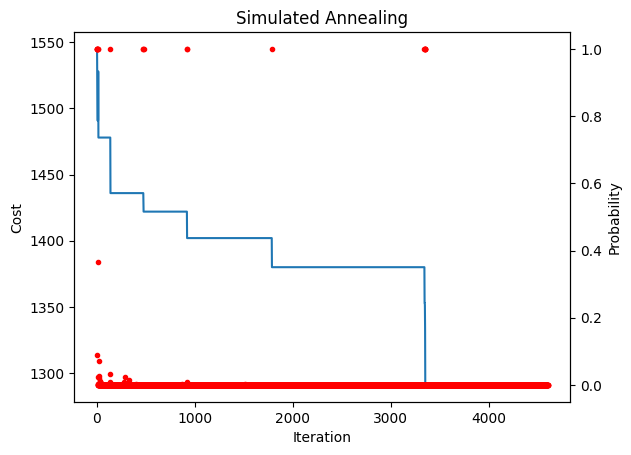

 59%|█████▉    | 13/22 [13:02<04:06, 27.42s/it]

Depth: 853
Transpiling with transpiler 1
Depth: 200
Transpiling with transpiler 2


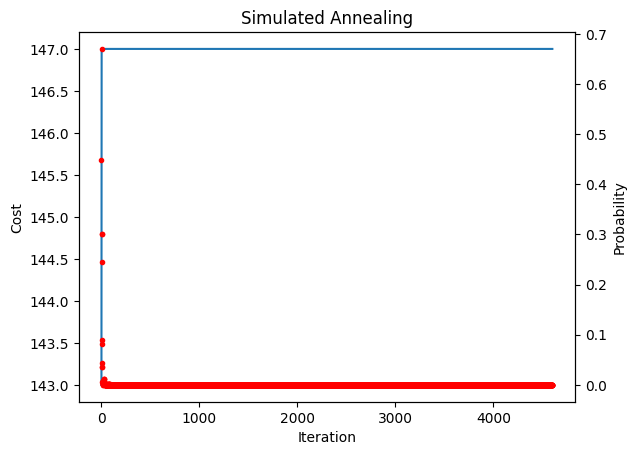

Depth: 128
Transpiling with transpiler 3


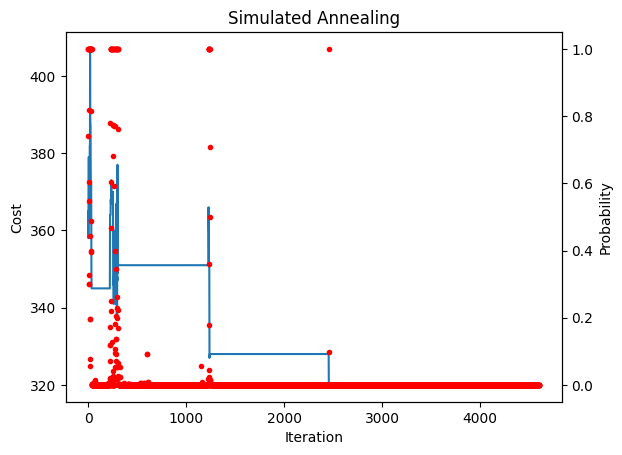

 64%|██████▎   | 14/22 [13:16<03:09, 23.72s/it]

Depth: 211
Transpiling with transpiler 1
Depth: 44
Transpiling with transpiler 2


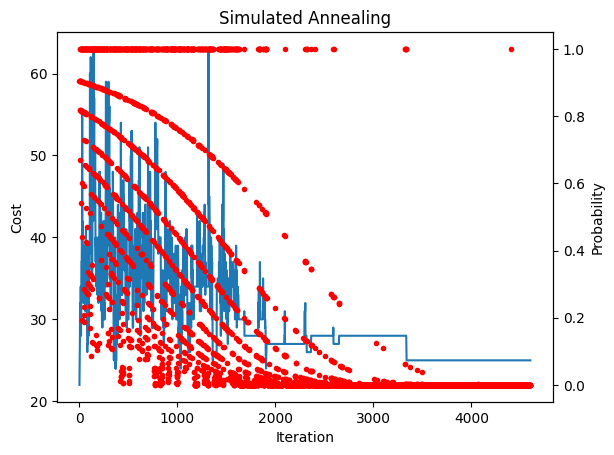

Depth: 42
Transpiling with transpiler 3


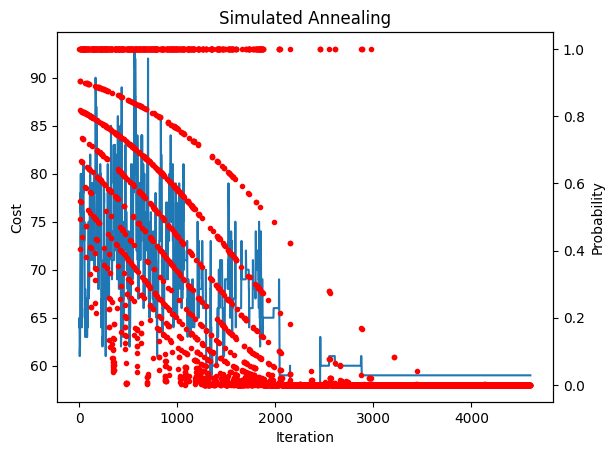

 68%|██████▊   | 15/22 [20:28<16:27, 141.14s/it]

Depth: 56
Transpiling with transpiler 1
Depth: 70
Transpiling with transpiler 2


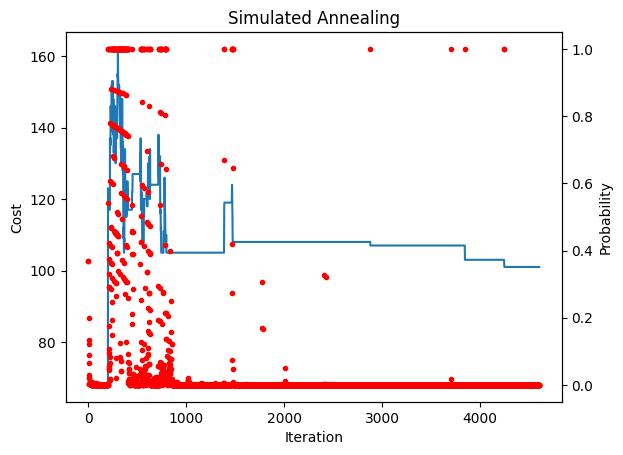

Depth: 71
Transpiling with transpiler 3


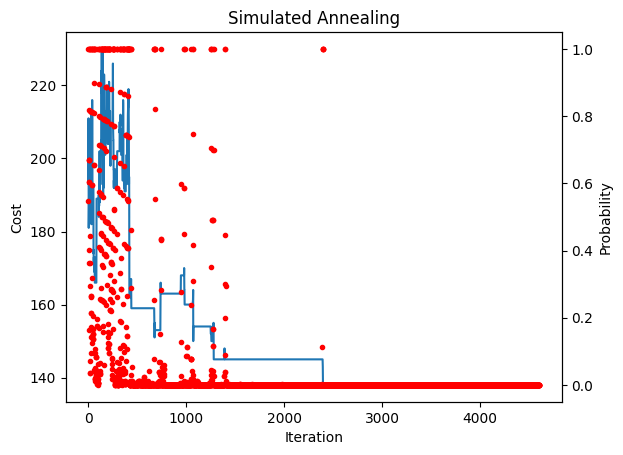

 73%|███████▎  | 16/22 [20:39<10:20, 103.34s/it]

Error: negative dimensions are not allowed
Transpiling with transpiler 1
Depth: 110
Transpiling with transpiler 2


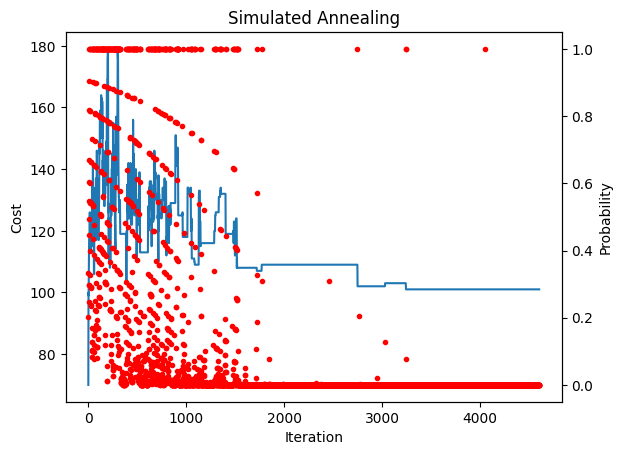

Depth: 65
Transpiling with transpiler 3


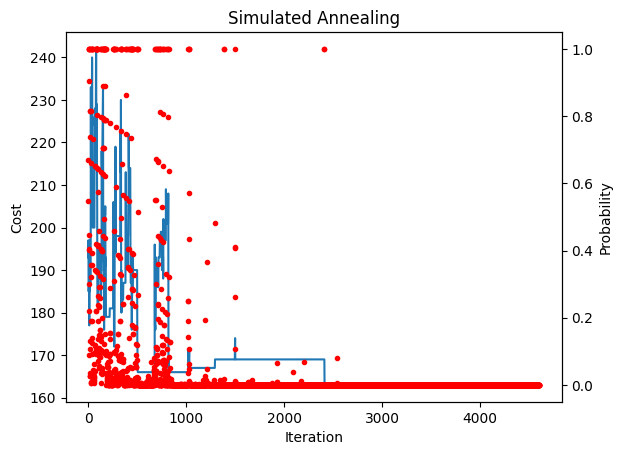

 77%|███████▋  | 17/22 [20:52<06:23, 76.66s/it] 

Depth: 105


 82%|████████▏ | 18/22 [27:44<11:43, 175.95s/it]

Transpiling with transpiler 1
Depth: 132
Transpiling with transpiler 2


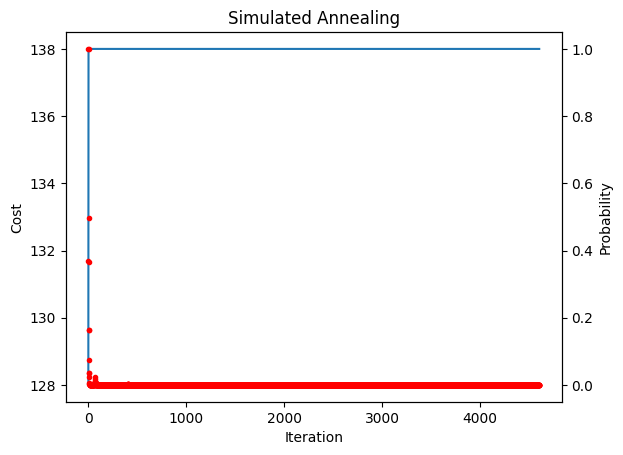

 86%|████████▋ | 19/22 [27:52<06:17, 125.90s/it]

Error: must be real number, not Measure
Transpiling with transpiler 1
Depth: 46
Transpiling with transpiler 2


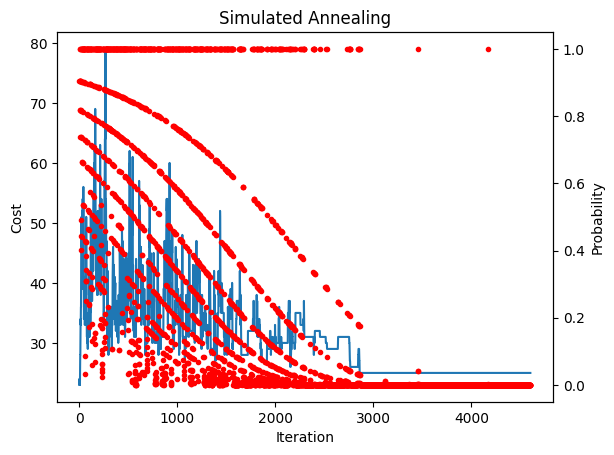

Depth: 44
Transpiling with transpiler 3


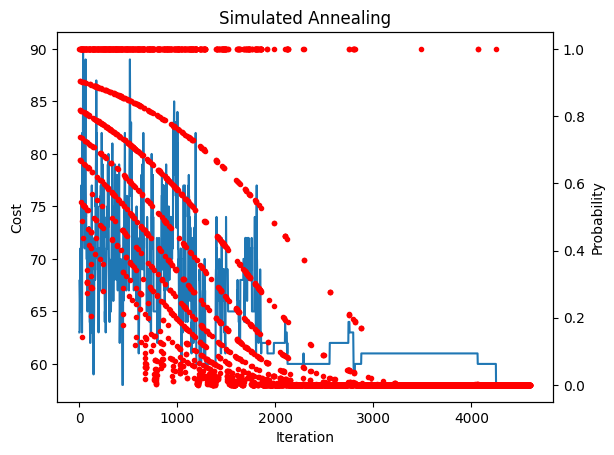

 95%|█████████▌| 21/22 [34:36<02:40, 160.82s/it]

Depth: 42
Transpiling with transpiler 1
Depth: 62
Transpiling with transpiler 2


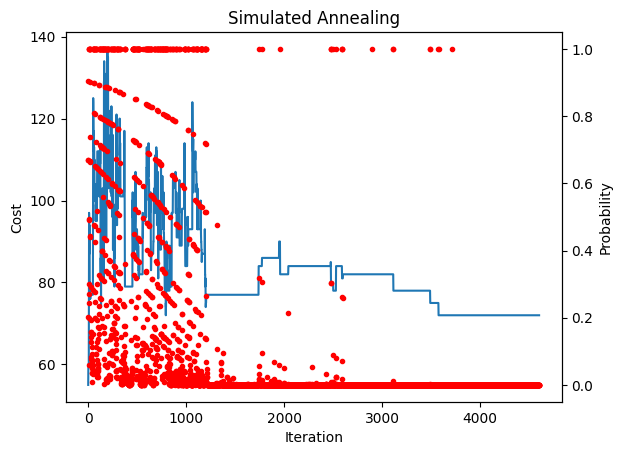

100%|██████████| 22/22 [34:42<00:00, 94.65s/it] 

Error: negative dimensions are not allowed


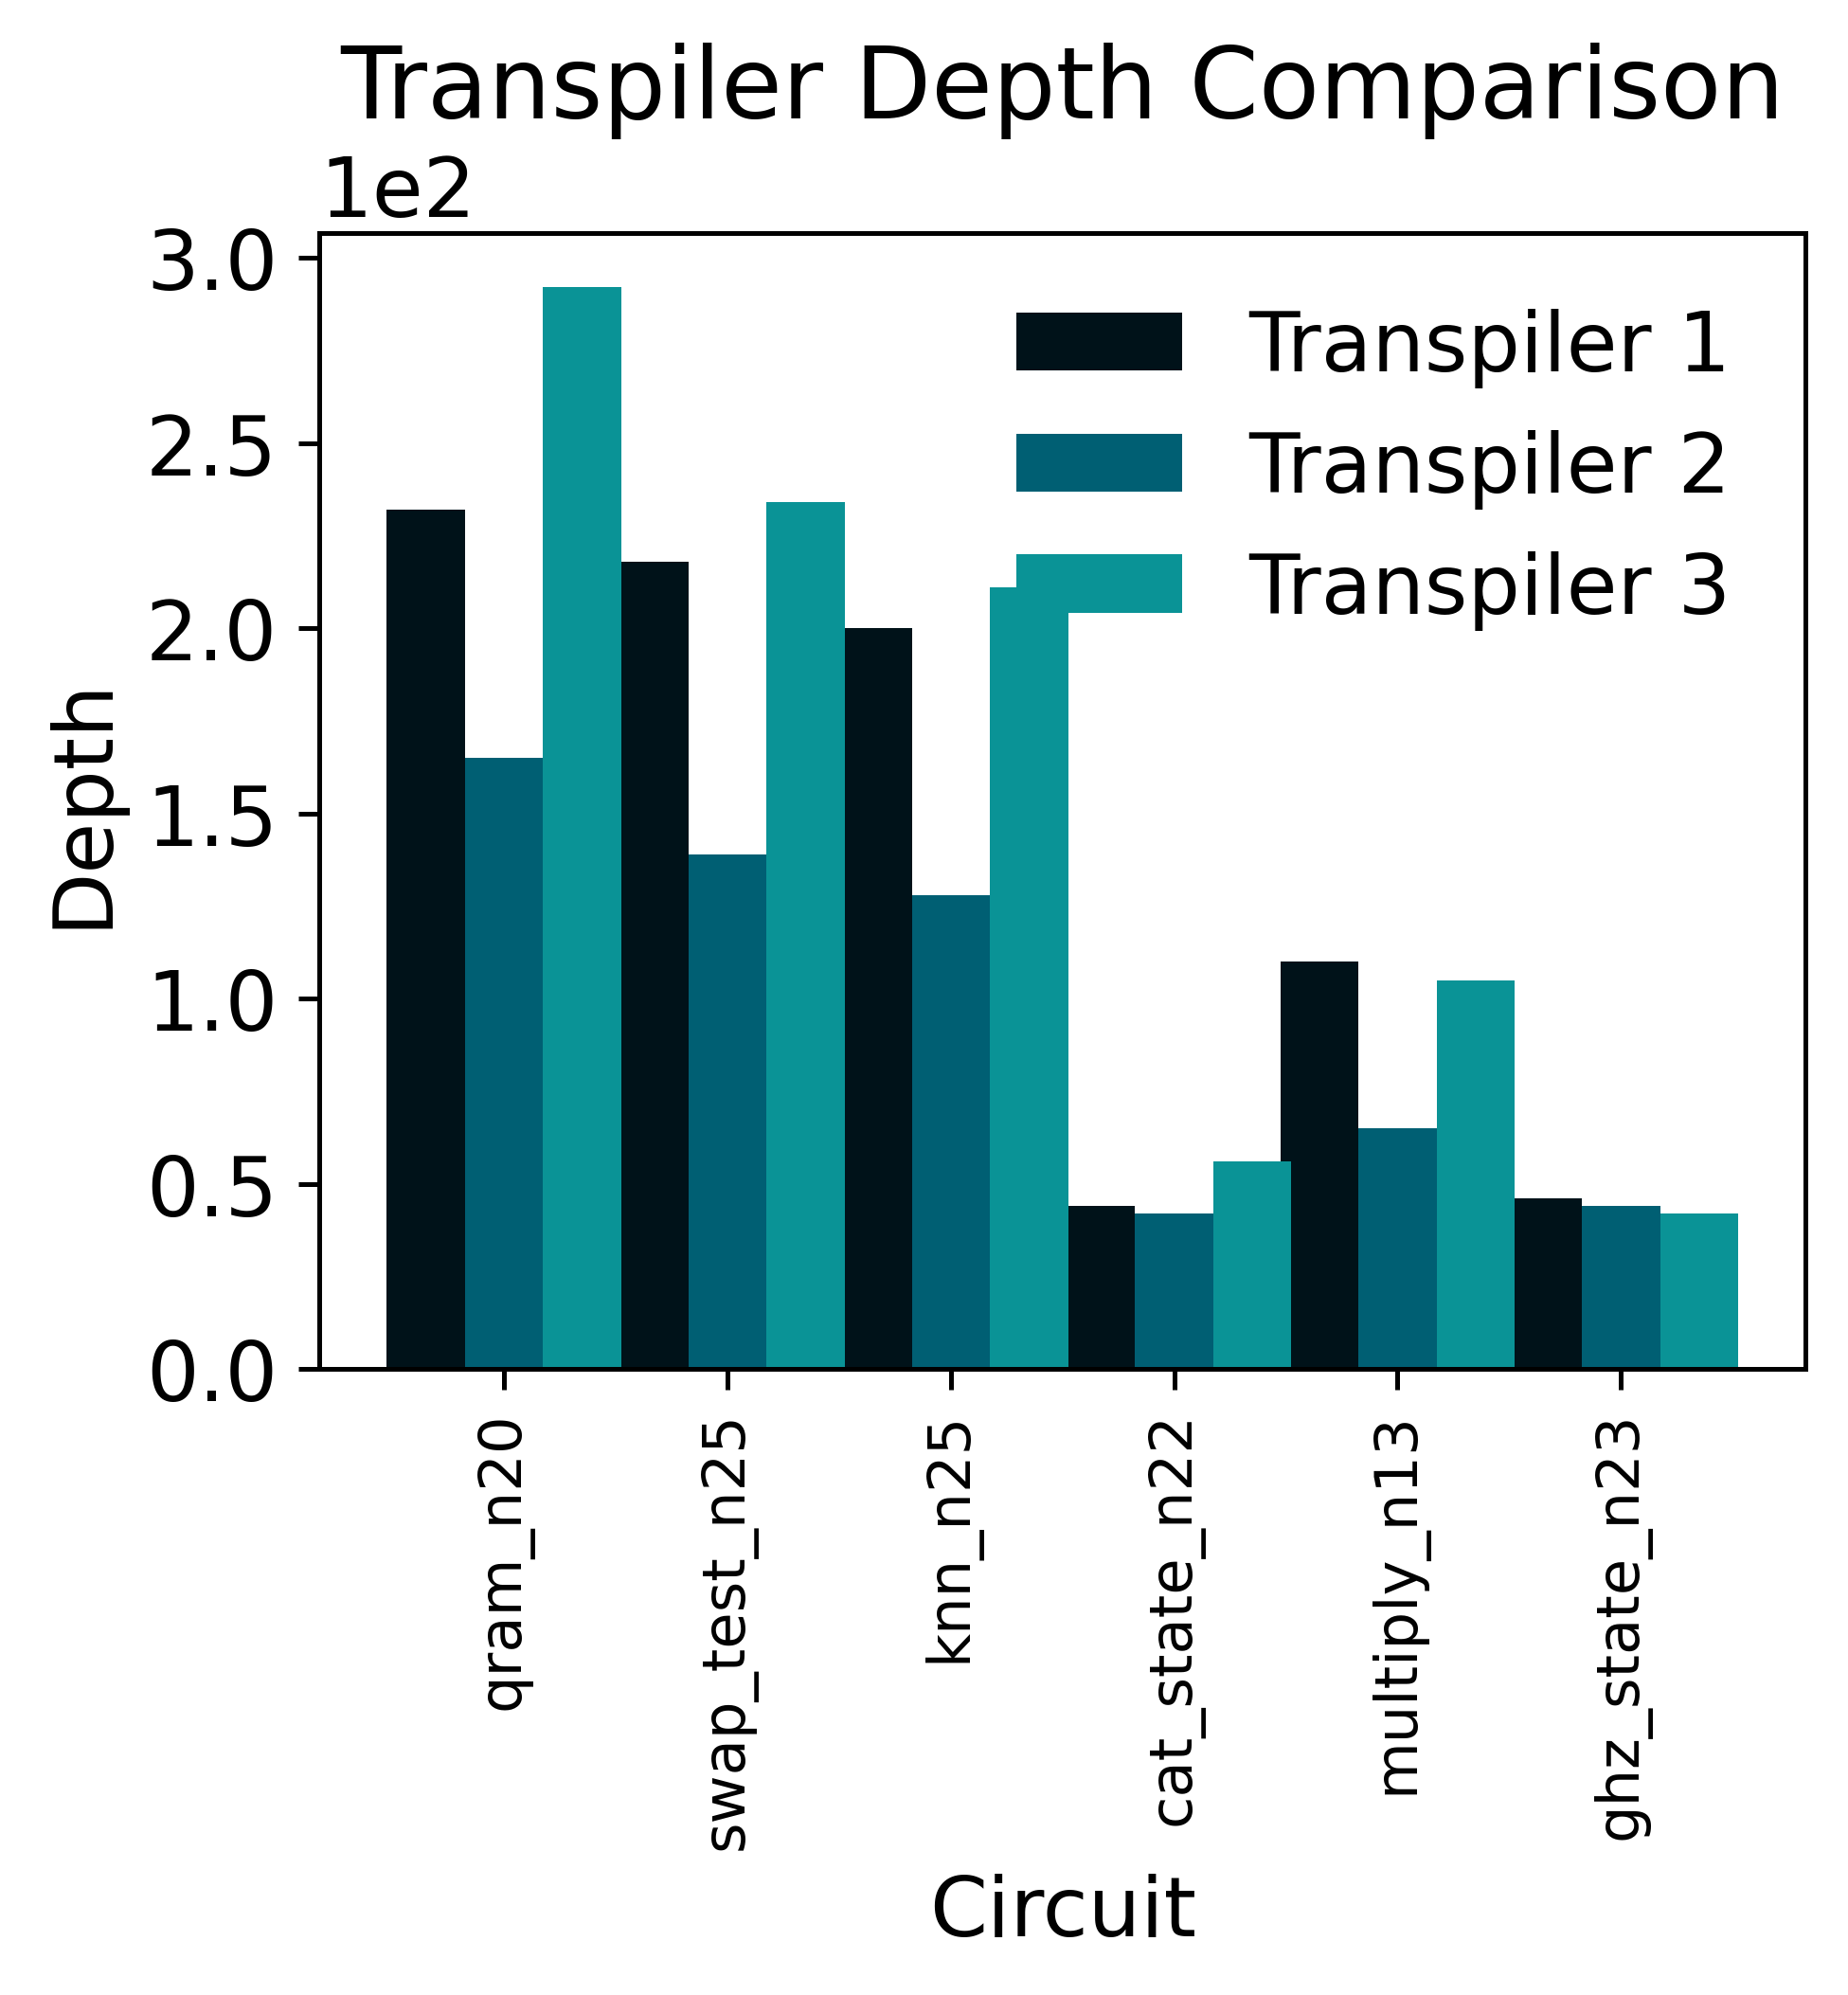

In [34]:
from transpile_benchy.main import Benchmark
from qiskit.transpiler.passes import RemoveBarriers, RemoveFinalMeasurements
from qiskit.transpiler.passes.layout import DenseLayout

# define some function that takes a circuit and returns a transpiled circuit


def t0(c):
    cc = transpile(
        c, coupling_map=coupling, basis_gates=["cx", "u3"], optimization_level=3
    )
    t0_pm = PassManager([RootiSwapWeylDecomposition()])
    return t0_pm.run(cc)


def t1(c):
    # qc_t0 = transpile(c, coupling_map=coupling, basis_gates=["cx", "u3"], optimization_level=3)
    prep_qc = transpile(
        c, basis_gates=["u", "cx", "swap"], coupling_map=coupling, optimization_level=3
    )
    # layout = Layout(qc_t0._layout.input_qubit_mapping)
    pm = PassManager()
    pm.append(
        [
            RemoveBarriers(),
            RemoveFinalMeasurements(),
            Unroller(["u", "cx"]),
            TrivialLayout(coupling),
        ]
    )
    pm.append([FullAncillaAllocation(coupling), EnlargeWithAncilla(), ApplyLayout()])
    pm.append(VirtualSwap(coupling, visualize=True))
    pm.append(OptimizeSwapBeforeMeasure())
    pm.append([Collect2qBlocks(), ConsolidateBlocks(), RootiSwapWeylDecomposition()])
    return pm.run(prep_qc)


def t2(c):
    # qc_t0 = transpile(c, coupling_map=coupling, basis_gates=["cx", "u3"], optimization_level=3)
    prep_qc = transpile(
        c, basis_gates=["u", "cx", "swap"], coupling_map=coupling, optimization_level=3
    )
    # layout = Layout(qc_t0._layout.input_qubit_mapping)
    pm = PassManager()
    pm.append(
        [
            RemoveBarriers(),
            RemoveFinalMeasurements(),
            Unroller(["u", "cx"]),
            DenseLayout(coupling),
        ]
    )
    pm.append([FullAncillaAllocation(coupling), EnlargeWithAncilla(), ApplyLayout()])
    pm.append(VirtualSwap(coupling, visualize=True))
    pm.append(OptimizeSwapBeforeMeasure())
    pm.append([Collect2qBlocks(), ConsolidateBlocks(), RootiSwapWeylDecomposition()])
    return pm.run(prep_qc)


b = Benchmark(t0, t1, t2, size="medium", prepath="../../../../transpile_benchy")
b.run()

# plot and save as svg
b.plot(save=True)

In [35]:
b.depth_list

[[232, 165, 292],
 [218, 139, 234],
 [200, 128, 211],
 [44, 42, 56],
 [110, 65, 105],
 [46, 44, 42]]

In [ ]:
# from virtual_swap.sqiswap_equiv import sel  # SessionEquivalenceLibrary

# qc4 = transpile(
#     qc, basis_gates=["u", "xx_plus_yy"], coupling_map=coupling, optimization_level=3
# )
# # bb.draw(output="mpl")

# pm = PassManager([CountOpsLongestPath()])
# qc4 = pm.run(qc4)

# print(f"Gate count: {qc4.count_ops()['xx_plus_yy']}")
# print(
#     f"Gate count critical path: {pm.property_set['count_ops_longest_path']['xx_plus_yy']}"
# )
# qc4.draw(output='mpl', fold=-1)

In [ ]:
# # run the pass
# pm = PassManager()
# # need some basic unroll and layout
# pm.append([Unroller(["u", "cx"]), TrivialLayout(coupling), ApplyLayout()])
# pm.append(VirtualSwap(coupling, visualize=True))
# pm.append(OptimizeSwapBeforeMeasure())

# # XXX use the PR version once merged into Qiskit
# pm.append([RootiSwapWeylDecomposition(), CountOpsLongestPath()])

# # set debug logging
# # import logging

# # logger = logging.getLogger("VSWAP")
# # logger.setLevel(logging.INFO)

# new_circ = pm.run(qc)

# print(f"Gate count: {new_circ.count_ops()['riswap']}")
# print(
#     f"Gate count critical path: {pm.property_set['count_ops_longest_path']['riswap']}"
# )

In [ ]:
# # set up some simple loop to mess with cooling rate, find a rate that makes it actually converge to a minima
# # range of cooling_rates between .1 and .001, log scale
# # cooling_rate_list = np.logspace(-3, -1, 5)
# cooling_rate_list = [0.01, 0.01, 0.01]
# scores = []
# for cooling_rate in cooling_rate_list:
#     print(f"Cooling rate: {cooling_rate}")
#     pm = PassManager()
#     # need some basic unroll and layout
#     pm.append([Unroller(["u", "cx"]), TrivialLayout(coupling), ApplyLayout()])
#     pm.append(VirtualSwap(coupling, sa_params=(5, cooling_rate, 1)))
#     pm.append(OptimizeSwapBeforeMeasure())
#     pm.append([RootiSwapWeylDecomposition(), CountOpsLongestPath()])
#     new_circ = pm.run(qc)

#     print(f"Gate count: {new_circ.count_ops()['riswap']}")
#     print(
#         f"Gate count critical path: {pm.property_set['count_ops_longest_path']['riswap']}"
#     )
#     scores.append(pm.property_set["scores"])

In [ ]:
# # set up some simple loop to mess with cooling rate, find a rate that makes it actually converge to a minima
# # range of cooling_rates between .1 and .001, log scale
# cooling_rate_list = np.logspace(-3, -1, 5)
# scores = []
# for cooling_rate in cooling_rate_list:
#     print(f"Cooling rate: {cooling_rate}")
#     pm = PassManager()
#     # need some basic unroll and layout
#     pm.append([Unroller(["u", "cx"]), TrivialLayout(coupling), ApplyLayout()])
#     pm.append(VirtualSwap(coupling, sa_params=(5, cooling_rate, 1)))
#     pm.append(OptimizeSwapBeforeMeasure())
#     pm.append([RootiSwapWeylDecomposition(), CountOpsLongestPath()])
#     new_circ = pm.run(qc)

#     print(f"Gate count: {new_circ.count_ops()['riswap']}")
#     print(
#         f"Gate count critical path: {pm.property_set['count_ops_longest_path']['riswap']}"
#     )
#     scores.append(pm.property_set["scores"])

In [ ]:
# import matplotlib.pyplot as plt

# for score, cooling_rate in zip(scores, cooling_rate_list):
#     plt.plot(score, "-.", label=f"cooling rate: {cooling_rate}")
# # x-axis log scale
# plt.xscale("log")
# plt.legend()

In [ ]:
# # run the pass
# pm = PassManager()
# # need some basic unroll and layout
# routing_pass = VirtualSwap(coupling_map=coupling)
# pm.append(
#     [
#         Unroller(["u", "cx"]),
#         SabreLayout(coupling_map=coupling, routing_pass=routing_pass),
#         ApplyLayout(),
#     ]
# )
# pm.append(routing_pass)
# pm.append(OptimizeSwapBeforeMeasure())

# # XXX use the PR version once merged into Qiskit
# pm.append(RootiSwapWeylDecomposition())
# # set debug logging
# import logging

# logging.basicConfig(level=logging.INFO)
# new_circ = pm.run(qc)
# # new_circ.draw(output="mpl")
# print(f"Gate count: {new_circ.count_ops()['riswap']}")
# print(f"Depth: {new_circ.depth()}")